# Gene Activity Scores

Compute Gene Activity Scores a la Cicero, but on fine grained clusters.

In [1]:
library(cicero)
library(Matrix)
library(ggplot2)
library(scales)
library(RColorBrewer)
library(DESeq2)
library(edgeR)
library(reshape2)
library(GenomicRanges)
library(rtracklayer)

Loading required package: monocle3

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Welcome to Bioconductor

    Vignette

In [2]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

## Load Data

In [3]:
pmat = readMM("../20200206_pmat_snapATAC/sessions/20200220_n74838/pmat.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  74838 467339

In [4]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20200220_n74838/metadata.tsv", header = T)
metaData$barcode = lapply(strsplit(rownames(metaData), '_'), "[[", 2)
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 74838     6

,sample,umap.1,umap.2,cluster,barcode,cells
,<fct>,<dbl>,<dbl>,<int>,<list>,<chr>
D0_AAACAACGACGATTAC,D0,6.545686,-7.701751,2,AAACAACGACGATTAC,D0_AAACAACGACGATTAC
D0_AAACAACGACTCACGG,D0,5.180663,-7.633298,2,AAACAACGACTCACGG,D0_AAACAACGACTCACGG
D0_AAACAACGAGCGCACT,D0,6.080648,-8.114705,2,AAACAACGAGCGCACT,D0_AAACAACGAGCGCACT
D0_AAACAACGATGGAACG,D0,3.584474,-7.276754,1,AAACAACGATGGAACG,D0_AAACAACGATGGAACG
D0_AAACACGCTACGCCAC,D0,5.299551,-8.133782,2,AAACACGCTACGCCAC,D0_AAACACGCTACGCCAC


In [18]:
fine_clusters = read.table("../20200206_pmat_snapATAC/sessions/20200220_n74838/fine_clusters.tsv", header = T)
head(fine_clusters)

,sample_barcode,clusters
,<fct>,<int>
1,D0_AAACAACGACGATTAC,1
2,D0_AAACAACGACTCACGG,18
3,D0_AAACAACGAGCGCACT,14
4,D0_AAACAACGATGGAACG,18
5,D0_AAACACGCTACGCCAC,14
6,D0_AAACACGCTAGACTTC,14


In [19]:
all(fine_clusters$sample_barcode==rownames(metaData))

[1] TRUE

In [7]:
regions = read.table("../20200206_pmat_snapATAC/sessions/20200220_n74838/peaks.bed")
names(regions) = c("chr", "bp1", "bp2")
regions$site_name <- paste(regions$chr, regions$bp1, regions$bp2, sep="_")
row.names(regions) <- regions$site_name
dim(regions)
head(regions)

[1] 467339      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr1_16146_16347,chr1,16146,16347,chr1_16146_16347
chr1_51458_51659,chr1,51458,51659,chr1_51458_51659
chr1_51688_52109,chr1,51688,52109,chr1_51688_52109
chr1_180685_181260,chr1,180685,181260,chr1_180685_181260
chr1_181267_181597,chr1,181267,181597,chr1_181267_181597
chr1_184384_184585,chr1,184384,184585,chr1_184384_184585


In [8]:
gz = "./out/20200417_default_20200220_n74838/coaccess.gt0.3.tsv.gz"
high_conns = read.table(gz, header=F, sep='\t')
colnames(high_conns) = c("Peak1", "Peak2", "coaccess")
high_conns$distance = abs(as.integer(lapply(strsplit(as.character(high_conns$Peak1), "_"), "[[", 2)) - as.integer(lapply(strsplit(as.character(high_conns$Peak2), "_"), "[[", 2)))
min(high_conns$coaccess)
dim(high_conns)
head(high_conns)

[1] 0.3000008

[1] 585102      4

,Peak1,Peak2,coaccess,distance
,<fct>,<fct>,<dbl>,<int>
1,chr10_100006055_100006360,chr10_99779363_99780088,0.3004101,226692
2,chr10_100006055_100006360,chr10_99906257_99907164,0.3203871,99798
3,chr10_100006055_100006360,chr10_99976944_99977384,0.3607012,29111
4,chr10_100006055_100006360,chr10_99983204_99984691,0.3491921,22851
5,chr10_100006055_100006360,chr10_99994339_99994936,0.3309449,11716
6,chr10_100006055_100006360,chr10_100006376_100006866,0.6237400,321


## Sanity Check

To see if metaData, matrix and regions are well-aligned

In [9]:
pmatRowSums = Matrix::rowSums(pmat)

In [10]:
# region_gr = read.table("../../../resources/GSE36570/DBRs.hg38.bed")
region_gr = read.table("../20200307_fine_clustering/beds/20200330_gridmap_peakwidthnorm_n20/idx5.bed")
colnames(region_gr) = c("chr", "start", "end")
region_gr = makeGRangesFromDataFrame(region_gr)

In [11]:
tmp_regions = regions[,c("chr", "bp1", "bp2")]
colnames(tmp_regions) = c("chr", "start", "end")
norm_reads_in_region = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(GRanges(tmp_regions), region_gr)))])/pmatRowSums

In [12]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)

[1] 0.1745582

[1] 0.002878289

[1] 0

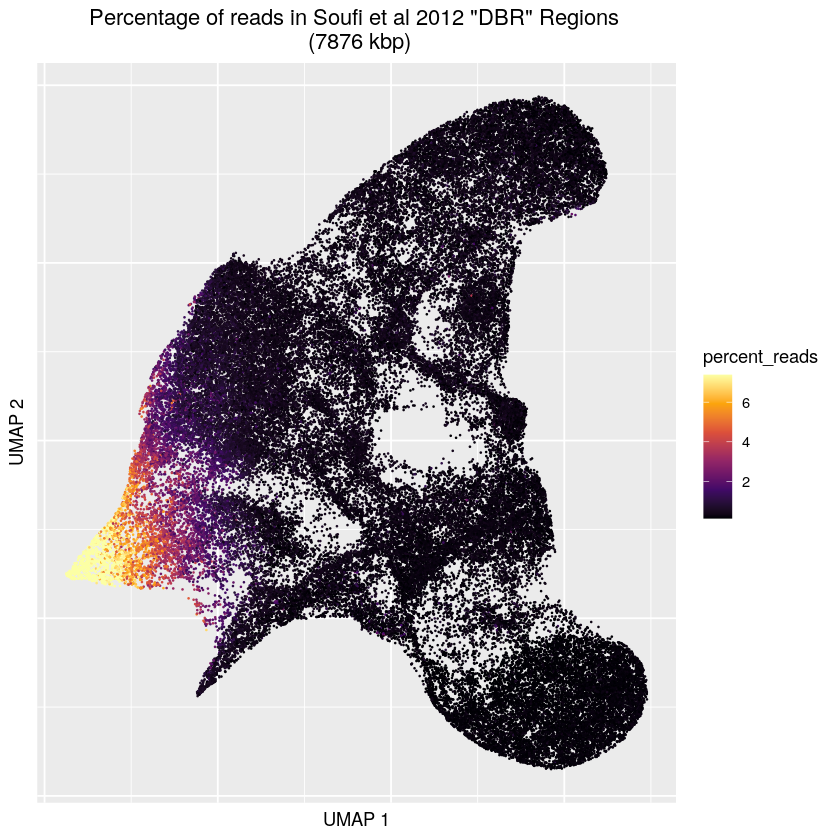

In [13]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(metaData, percent_reads=100*norm_reads_in_region)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.1, alpha=1, aes(x=umap.1 , y=umap.2, col=percent_reads)) +
ggtitle(sprintf("Percentage of reads in Soufi et al 2012 \"DBR\" Regions \n (%d kbp)",  
               as.integer(sum(width(region_gr))/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(quantile(100*norm_reads_in_region, 0.1), 
                               quantile(100*norm_reads_in_region, 0.99)), 
                      oob=squish, option = "B") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

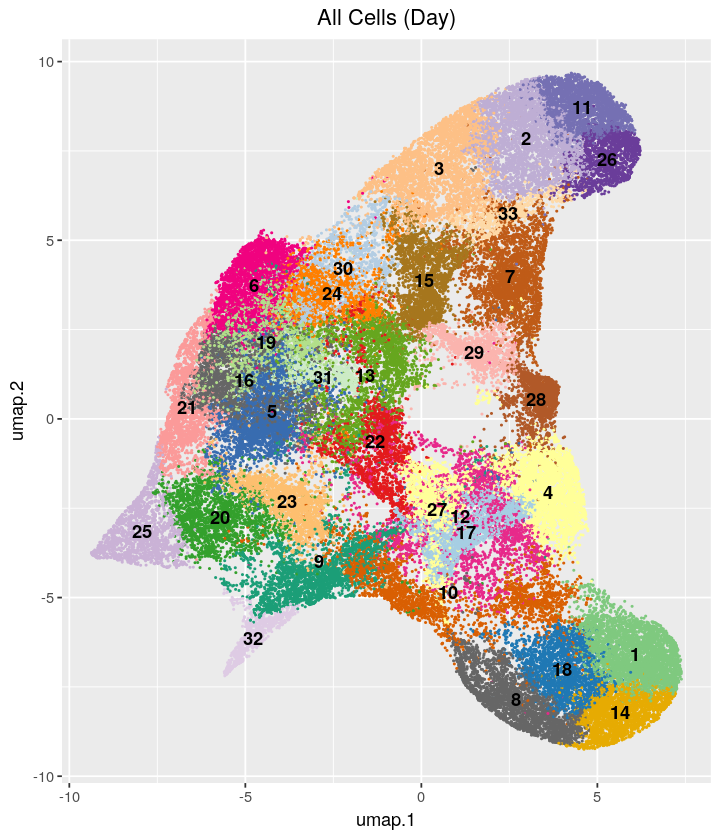

In [22]:
options(repr.plot.width = 6, repr.plot.height = 7)

df = data.frame(metaData, clst=as.factor(fine_clusters$clusters))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=clst)) +
# scale_color_brewer( palette = "Set1") +
scale_color_manual(values=col_vector) +
geom_text(data=data.frame(aggregate(metaData[,c("umap.1", "umap.2")], list(fine_clusters$clusters), mean)),
         aes(x=umap.1, y=umap.2, label=Group.1), fontface = "bold") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5),
      legend.positio = "none")
# guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

## Load Gene Annotations

In [23]:
gencode.basic.hg38 = import.gff(gzfile("../../../resources/GENCODE/gencode.v33.chr_patch_hapl_scaff.basic.annotation.gtf.gz"))

Warning message in readGFF(filepath, version = version, filter = filter):
"connection is not positioned at the start of the file, rewinding it"


In [24]:
gencode.basic.hg38 = keepStandardChromosomes(gencode.basic.hg38, pruning.mode = "coarse")

In [25]:
gencode.basic.tx.hg38 = subset(subset(gencode.basic.hg38, gene_type=="protein_coding"), type=="transcript")
head(gencode.basic.tx.hg38, 3)
length(gencode.basic.tx.hg38)

GRanges object with 3 ranges and 21 metadata columns:
      seqnames        ranges strand |   source       type     score     phase
         <Rle>     <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1]     chr1   65419-71585      + |   HAVANA transcript      <NA>      <NA>
  [2]     chr1   69055-70108      + |  ENSEMBL transcript      <NA>      <NA>
  [3]     chr1 450703-451697      - |   HAVANA transcript      <NA>      <NA>
                gene_id      gene_type   gene_name       level     hgnc_id
            <character>    <character> <character> <character> <character>
  [1] ENSG00000186092.6 protein_coding       OR4F5           2  HGNC:14825
  [2] ENSG00000186092.6 protein_coding       OR4F5           3  HGNC:14825
  [3] ENSG00000284733.1 protein_coding      OR4F29           2  HGNC:31275
               havana_gene     transcript_id transcript_type transcript_name
               <character>       <character>     <character>     <character>
  [1] OTTHUMG00000001094.4 

[1] 58073

In [26]:
gene_anno = data.frame(gencode.basic.tx.hg38)
head(gene_anno)

,seqnames,start,end,width,strand,source,type,score,phase,gene_id,⋯,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<int>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr1,65419,71585,6167,+,HAVANA,transcript,NA,NA,ENSG00000186092.6,⋯,protein_coding,OR4F5-202,NA,basic,OTTHUMT00000003223.4,NA,NA,NA,ENSP00000493376.2,NA
2,chr1,69055,70108,1054,+,ENSEMBL,transcript,NA,NA,ENSG00000186092.6,⋯,protein_coding,OR4F5-201,NA,CCDS,NA,NA,NA,NA,ENSP00000334393.3,CCDS30547.1
3,chr1,450703,451697,995,-,HAVANA,transcript,NA,NA,ENSG00000284733.1,⋯,protein_coding,OR4F29-201,NA,CCDS,OTTHUMT00000007999.3,NA,NA,NA,ENSP00000409316.1,CCDS72675.1
4,chr1,685679,686673,995,-,HAVANA,transcript,NA,NA,ENSG00000284662.1,⋯,protein_coding,OR4F16-201,NA,CCDS,OTTHUMT00000007334.3,NA,NA,NA,ENSP00000329982.2,CCDS41221.1
5,chr1,925731,944574,18844,+,HAVANA,transcript,NA,NA,ENSG00000187634.12,⋯,protein_coding,SAMD11-202,5,CCDS,OTTHUMT00000276866.3,NA,NA,NA,ENSP00000342313.3,CCDS2.2
6,chr1,925741,944581,18841,+,ENSEMBL,transcript,NA,NA,ENSG00000187634.12,⋯,protein_coding,SAMD11-213,5,appris_alternative_2,NA,NA,NA,NA,ENSP00000480870.1,NA


In [27]:
# rename some columns to match requirements
gene_anno$chromosome <-  gene_anno$seqnames
gene_anno$gene <- gene_anno$gene_id
gene_anno$transcript <- gene_anno$transcript_name
gene_anno$symbol <- gene_anno$gene_name

In [28]:
pos <- subset(gene_anno, strand == "+")
pos <- pos[order(pos$start),] 
# remove all but the first exons per transcript
pos <- pos[!duplicated(pos$transcript),] 
# make a 1 base pair marker of the TSS
pos$end <- pos$start + 1 

neg <- subset(gene_anno, strand == "-")
neg <- neg[order(neg$start, decreasing = TRUE),] 
# remove all but the first exons per transcript
neg <- neg[!duplicated(neg$transcript),] 
neg$start <- neg$end - 1

gene_annotation_sub <- rbind(pos, neg)

In [29]:
gene_annotation_sub <- gene_annotation_sub[,c("chromosome", "start", "end", "transcript_name")]

# Rename the gene symbol column to "gene" to use all TSSes
names(gene_annotation_sub)[4] <- "gene"

In [30]:
dim(gene_annotation_sub)
head(gene_annotation_sub)

[1] 58022     4

,chromosome,start,end,gene
,<fct>,<dbl>,<dbl>,<chr>
58061,chrM,3307,3308,MT-ND1-201
58062,chrM,4470,4471,MT-ND2-201
58063,chrM,5904,5905,MT-CO1-201
58064,chrM,7586,7587,MT-CO2-201
58065,chrM,8366,8367,MT-ATP8-201
58066,chrM,8527,8528,MT-ATP6-201


## Make pseudo-bulk matrix

In [31]:
agg_matrix = sparseMatrix(i=fine_clusters$clusters,
                         j=seq(1,nrow(pmat)),
                         x=1L,
                         dims=c(length(table(fine_clusters$clusters)), nrow(pmat)))

In [32]:
cts = as.matrix(agg_matrix %*% pmat)
colnames(cts) = rownames(regions)
rownames(cts) = paste("cluster", seq(1,nrow(cts)), sep="_")
cts = t(cts)
head(cts)

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,⋯,cluster_24,cluster_25,cluster_26,cluster_27,cluster_28,cluster_29,cluster_30,cluster_31,cluster_32,cluster_33
chr1_16146_16347,7,9,7,5,16,5,5,14,6,0,⋯,6,0,2,3,2,1,6,8,0,0
chr1_51458_51659,0,3,0,0,1,0,1,1,0,0,⋯,0,0,0,0,1,0,2,0,0,0
chr1_51688_52109,1,13,18,0,3,2,6,1,0,0,⋯,0,0,1,0,0,0,3,2,0,0
chr1_180685_181260,47,29,21,25,67,31,35,52,11,8,⋯,23,16,18,15,3,5,28,27,1,9
chr1_181267_181597,30,54,21,10,66,35,54,29,27,10,⋯,18,16,20,26,5,8,35,33,15,11
chr1_184384_184585,11,7,10,5,30,10,13,9,12,13,⋯,7,4,0,10,2,5,9,24,5,0


In [33]:
cluster_metadata = data.frame(nbarcodes=Matrix::rowSums(agg_matrix))
rownames(cluster_metadata) = colnames(cts)

input_cds <-  new_cell_data_set(cts,  # need to transpose based on tutorial
              cell_metadata = cluster_metadata,
              gene_metadata = regions)

Warning message in new_cell_data_set(cts, cell_metadata = cluster_metadata, gene_metadata = regions):
"Warning: gene_metadata must contain a column verbatim named 'gene_short_name' for certain functions."


In [34]:
input_cds <- annotate_cds_by_site(input_cds, gene_annotation_sub)

In [35]:
sum(!is.na(fData(input_cds)$gene))

[1] 18156

In [36]:
# generate unnormalized gene activity matrix
unnorm_ga <- build_gene_activity_matrix(input_cds, high_conns,
                                       coaccess_cutoff=0.1)

In [37]:
# remove any rows/columns with all zeroes
unnorm_ga <- unnorm_ga[!Matrix::rowSums(unnorm_ga) == 0, 
                       !Matrix::colSums(unnorm_ga) == 0]

In [38]:
norm_ga = t(t(as.matrix(unnorm_ga))/estimateSizeFactorsForMatrix(unnorm_ga))

In [39]:
head(norm_ga)

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,⋯,cluster_24,cluster_25,cluster_26,cluster_27,cluster_28,cluster_29,cluster_30,cluster_31,cluster_32,cluster_33
A2M-201,4.813983,7.982244,5.07031,13.27617,11.58451,5.255648,24.90377,3.130655,11.42635,7.940387,⋯,8.195779,2.344658,9.523302,8.543716,72.71424,32.97103,8.124559,6.338914,0.00000,14.24706
A2ML1-201,4.813983,155.083603,219.03739,19.31079,260.51013,440.890464,133.03854,4.472364,122.42515,34.937702,⋯,351.394006,234.465807,111.105186,18.796175,25.29191,80.92888,228.300118,159.625382,73.99088,109.22747
A4GALT-202,198.686200,190.433541,179.48897,193.71135,236.49347,258.694670,193.98723,192.311642,286.47485,171.512354,⋯,245.873357,269.635679,253.954712,237.515300,192.85082,188.83406,290.046770,254.709093,450.99201,256.44710
AAAS-202,388.182070,374.025159,335.65452,336.12841,351.77344,353.880293,418.77649,357.789102,379.51796,449.425889,⋯,304.268280,361.077343,361.885464,395.574043,464.73886,389.65758,359.917980,334.809917,433.37513,322.93338
AAAS-208,482.711187,457.268564,444.15915,482.76972,465.92321,462.497017,481.69127,443.211250,449.70838,541.534376,⋯,455.890183,466.586957,368.234332,446.836338,505.83822,512.54959,463.099885,422.978449,510.88938,517.64321
AACS-201,419.254141,424.199266,414.75135,421.82004,416.47715,423.371638,408.94606,444.552959,430.93652,460.542431,⋯,454.865711,433.761744,450.769613,415.224590,417.31653,404.64441,470.411988,424.707244,422.80501,455.90595


## Playground

In [40]:
data.use = norm_ga
group = factor(colnames(data.use), levels = colnames(data.use))
y = DGEList(counts=data.use, group=group)

In [41]:
design <- model.matrix(~0+group, data=y$samples)
colnames(design) <- levels(y$samples$group)

In [42]:
fit <- glmFit(y, design, dispersion = 0.4^2)

In [43]:
# contrast vector (one/many-vs-rest)
many = c("cluster_25")
cont = rep(-1/(ncol(data.use)-length(many)),ncol(data.use))
cont[(group %in% many)] = 1/length(many)

In [855]:
# contrast vector (one/many-vs-one/many)
pos = c("cluster_25")
neg = c("cluster_1", "cluster_30", "cluster_2", "cluster_3", "cluster_32")
cont = rep(0,ncol(data.use))
cont[(group %in% pos)] = 1/length(pos)
cont[(group %in% neg)] = -1/length(neg)

In [44]:
# one-vs-all for a cluster
lrt <- glmLRT(fit, contrast=cont)

In [45]:
cur_diff_genes = rownames(lrt$table[order((1/lrt$table$PValue)*ifelse(lrt$table$logFC>0, -1, 1)),])  

In [46]:
cur_diff_genes_maxed = cur_diff_genes[rowMaxs(norm_ga[cur_diff_genes,])==norm_ga[cur_diff_genes,"cluster_25"]]
head(cur_diff_genes_maxed, 40)
head(cur_diff_genes, 40)

[1] "CDH2-202"     "DZANK1-202"   "GAB2-201"     "TSPAN8-201"   "RBM33-203"   
 [6] "FEZ2-201"     "TESPA1-212"   "CCDC168-201"  "C3orf20-203"  "LRTM1-202"   
[11] "MTCL1-207"    "MIER3-205"    "TUBA1C-202"   "C12orf49-204" "LUC7L-203"   
[16] "ZDBF2-202"    "ABLIM3-211"   "LIMS1-203"    "MAGI2-204"    "ARNT2-204"   
[21] "ATP1A1-203"   "AEBP2-209"    "CLC-201"      "RACGAP1-221"  "MOK-208"     
[26] "PBX1-219"     "ODF1-202"     "ZHX3-201"     "CLDN22-201"   "ACMSD-201"   
[31] "SCEL-205"     "HSD17B2-201"  "MOBP-206"     "TFDP2-224"    "IL5RA-206"   
[36] "IL31RA-202"   "ADH7-202"     "MARCHF10-202" "OR4D1-202"    "RIPOR2-214"

[1] "CDH2-202"     "DZANK1-202"   "GAB2-201"     "TSPAN8-201"   "RBM33-203"   
 [6] "FEZ2-201"     "TESPA1-212"   "CCDC168-201"  "C3orf20-203"  "LRTM1-202"   
[11] "MTCL1-207"    "MIER3-205"    "TUBA1C-202"   "C12orf49-204" "LUC7L-203"   
[16] "ZDBF2-202"    "ABLIM3-211"   "ROS1-202"     "LIMS1-203"    "MAGI2-204"   
[21] "ARNT2-204"    "ATP1A1-203"   "AEBP2-209"    "PLAC8L1-201"  "CLC-201"     
[26] "RACGAP1-221"  "MOK-208"      "PBX1-219"     "ODF1-202"     "ZHX3-201"    
[31] "CLDN22-201"   "ACMSD-201"    "SCEL-205"     "HSD17B2-201"  "MOBP-206"    
[36] "TFDP2-224"    "IL5RA-206"    "IL31RA-202"   "ADH7-202"     "MARCHF10-202"

In [50]:
grep("MAP2", cur_diff_genes)

[1]   533  2154  4619  4909  7123  8231 10383 10700 10976 12257 13379 16402

In [966]:
# GENE = cur_diff_genes[47]
GENE = cur_diff_genes_maxed[14]
GENE

[1] "PBX1-219"

In [85]:
GENE = "SNCA-212"

In [95]:
query = "^SYT14"
rownames(norm_ga)[grepl(query, rownames(norm_ga))]
GENE = rownames(norm_ga)[grepl(query, rownames(norm_ga))][1]

[1] "SYT14-202"

In [96]:
max(norm_ga[GENE, ])
median(norm_ga[GENE, ])
min(norm_ga[GENE, ])
max(norm_ga[GENE, ])/min(norm_ga[GENE, ])

df = gene_annotation_sub[gene_annotation_sub$gene==GENE,]
paste(paste(df$chromosome, df$start-5000, sep=':'), df$start+5000, sep='-')

[1] 417.371

[1] 327.7568

[1] 244.0341

[1] 1.710298

[1] "chr1:209933174-209943174"

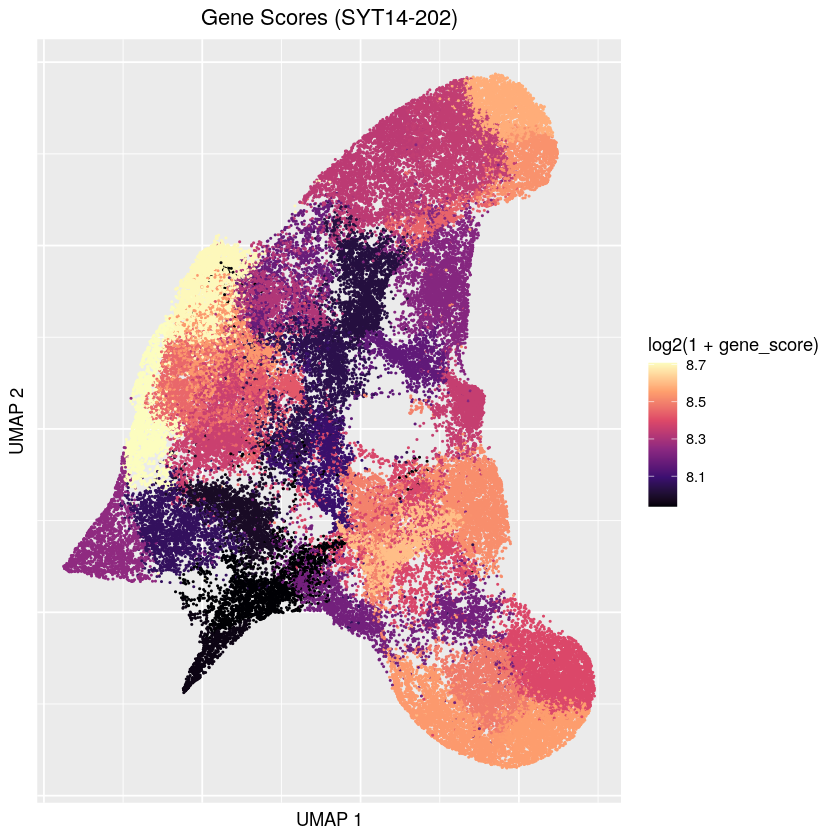

In [97]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(metaData, gene_score=as.numeric(norm_ga[GENE,])[fine_clusters$clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=log2(1+gene_score))) +
ggtitle(sprintf("Gene Scores (%s)", GENE)) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

In [94]:
TMP_PATH = "tmp_ordered.txt"
genes_to_write = lapply(strsplit(cur_diff_genes, "-"), "[[", 1)

fileConn = file(TMP_PATH)
# writeLines(unique(c(unlist(genes_to_write), gene_anno$gene_name)), fileConn)
writeLines(unique(unlist(genes_to_write)), fileConn)
close(fileConn)

## mRNA analysis

From Cachiarelli et al 2015

In [372]:
# load bulk RNA-seq data
fpkm = read.table("/users/surag/kundajelab/scATAC-reprog/resources/GSE62777/RNAseq.FPKM.tsv", sep='\t', header=T)
fpkm$gene_id = NULL
fpkm$locus=NULL
tpm = fpkm
tpm[,2:ncol(tpm)] = 1e6*t(t(tpm[,2:ncol(tpm)])/colSums(tpm[,2:ncol(tpm)]))

# removing genes with dup names
tpm = tpm[!duplicated(tpm$gene_short_name),]
rownames(tpm) = tpm$gene_short_name
tpm$gene_short_name = NULL

tpm["GAPDH",]

,hiF.T_P14,X2dd_DOX_plus,X5dd_DOX_plus,X8dd_DOX_plus,X10dd_DOX_plus_SSEA3_pos,X14dd_DOX_plus_SSEA3_pos,X20dd_DOX_plus_TRA_plus,X24dd_TRA_pos_DOX_plus,X24dd_TRA_pos_DOX_minus,hIPSC.T_P10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GAPDH,7803.64,4963.505,3908.693,3839.776,3795.548,3364.503,3032.412,3790.955,5598.224,4731.256


In [1061]:
gene_set_to_plot = lapply(strsplit(cur_diff_genes, "-"), "[[", 1)[1:100]
# gene_set_to_plot = names(rev(sort(table(e2g_uniq$g)[table(e2g_uniq$g)>2])))

In [1062]:
colMedians(as.matrix(log2(1+tpm)[rownames(tpm) %in% gene_set_to_plot, ]))

[1] 3.756953 2.960641 2.401137 2.742933 2.750631 2.774877 2.294035 2.364286
 [9] 2.579177 2.681925

[1] 911

No id variables; using all as measure variables



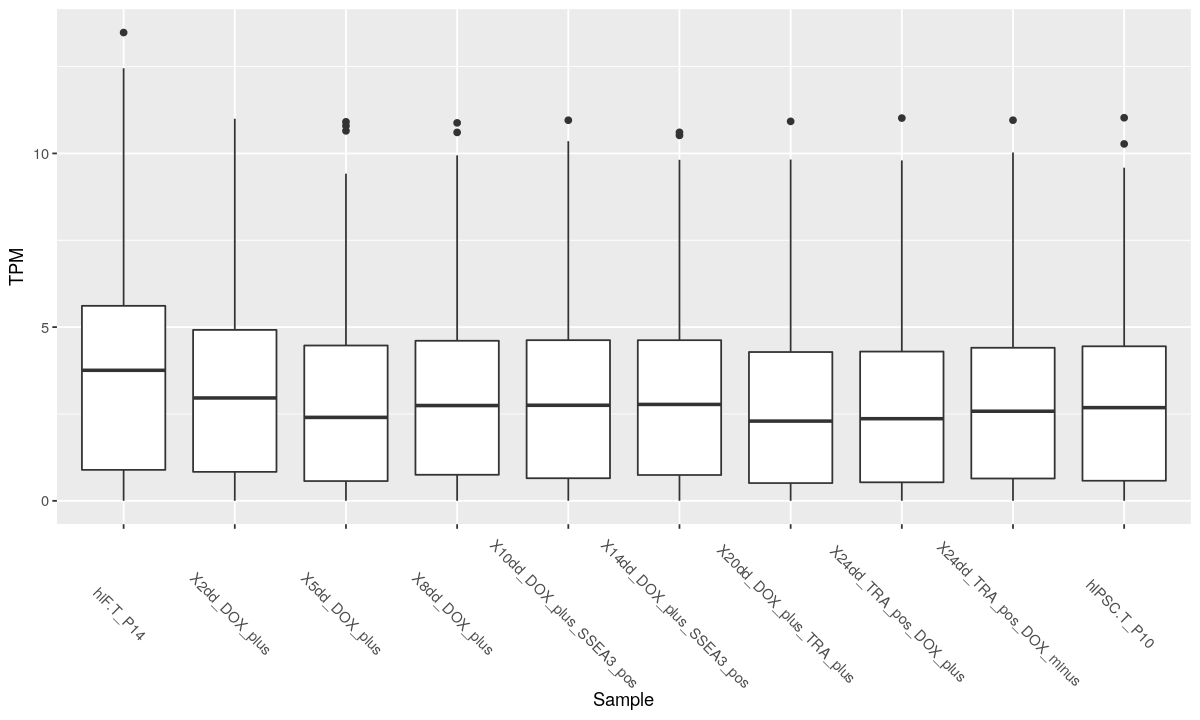

In [1063]:
options(repr.plot.width = 10, repr.plot.height = 6)

sum(gene_set_to_plot %in% rownames(tpm))

ggplot(melt(log2(1+tpm)[rownames(tpm) %in% gene_set_to_plot, ]), aes(x=variable, y=value)) +
# ggplot(melt(t(scale(t(log2(1+tpm)[rownames(tpm) %in% gene_set_to_plot, ])))), aes(x=Var2, y=value)) +
stat_boxplot() +
# geom_line(aes(group=Var1),size=0.1) + geom_point() +
theme(axis.text.x = element_text(angle = -45)) +
ylab("TPM") + xlab("Sample")
# geom_boxplot(outlier.shape = NA) + geom_jitter(width = 0.2)
# coord_cartesian(ylim=c(0,8)) 

In [960]:
filtered_gene_set = unlist(lapply(strsplit(cur_diff_genes, ":"), "[[", 1))[1:200]

# filtered_gene_set = filtered_gene_set[rowMaxs(as.matrix(tpm[filtered_gene_set,]))==rowMaxs(as.matrix(tpm[filtered_gene_set,c("X2dd_DOX_plus", "X5dd_DOX_plus", "X8dd_DOX_plus")]))]
filtered_gene_set = filtered_gene_set[(tpm[filtered_gene_set, 1]<1)&(tpm[filtered_gene_set, 10]<1)&
                                      (rowMaxs(as.matrix(tpm[filtered_gene_set,]))>5)]

filtered_gene_set = filtered_gene_set[!is.na(filtered_gene_set)]

for (x in unique(filtered_gene_set)) {
    cat(sprintf("%s\n", x))
}

In [831]:
head(gene_anno)
gt1_tx = names(table(gene_anno$gene)[table(gene_anno$gene)>1])

,seqid,source,type,start,end,score,strand,phase,gene_id,transcript_id,gene_name,exon_number,exon_id,chromosome,gene,transcript,symbol
,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>
1,chr1,refGene,transcript,11874,14409,NA,+,NA,DDX11L1,NR_046018,DDX11L1,NA,NA,chr1,DDX11L1,NR_046018,DDX11L1
5,chr1,refGene,transcript,14362,29370,NA,-,NA,WASH7P,NR_024540,WASH7P,NA,NA,chr1,WASH7P,NR_024540,WASH7P
17,chr1,refGene,transcript,17369,17436,NA,-,NA,MIR6859-1,NR_106918,MIR6859-1,NA,NA,chr1,MIR6859-1,NR_106918,MIR6859-1
19,chr1,refGene,transcript,17369,17436,NA,-,NA,MIR6859-2,NR_107062,MIR6859-2,NA,NA,chr1,MIR6859-2,NR_107062,MIR6859-2
21,chr1,refGene,transcript,17369,17436,NA,-,NA,MIR6859-3,NR_107063,MIR6859-3,NA,NA,chr1,MIR6859-3,NR_107063,MIR6859-3
23,chr1,refGene,transcript,17369,17436,NA,-,NA,MIR6859-4,NR_128720,MIR6859-4,NA,NA,chr1,MIR6859-4,NR_128720,MIR6859-4


In [832]:
head(gt1_tx)

[1] "A1CF"    "A2M"     "A2M-AS1" "A2ML1"   "A4GALT"  "AAAS"

In [842]:
range_diff = aggregate(gene_anno$start, by=list(gene_anno$gene), function(x) diff(range(x)))

In [846]:
rownames(range_diff) = range_diff$Group.1

In [853]:
tail(range_diff[range_diff$x>1000,])

,Group.1,x
,<chr>,<int>
ZP3,ZP3,27428
ZSCAN12,ZSCAN12,5917
ZSCAN18,ZSCAN18,23763
ZSCAN5A,ZSCAN5A,1633
ZXDC,ZXDC,21300
ZYX,ZYX,143380636


In [854]:
gene_anno[gene_anno$gene=="ZSCAN12", ]

,seqid,source,type,start,end,score,strand,phase,gene_id,transcript_id,gene_name,exon_number,exon_id,chromosome,gene,transcript,symbol
,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>
665394,chr6,refGene,transcript,28378821,28399747,NA,-,NA,ZSCAN12,NR_028077,ZSCAN12,NA,NA,chr6,ZSCAN12,NR_028077,ZSCAN12
752984,chr6,refGene,transcript,28384738,28399747,NA,-,NA,ZSCAN12,NM_001163391,ZSCAN12,NA,NA,chr6,ZSCAN12,NM_001163391,ZSCAN12
1095941,chr6,refGene,transcript,28378821,28399747,NA,-,NA,ZSCAN12,NR_136511,ZSCAN12,NA,NA,chr6,ZSCAN12,NR_136511,ZSCAN12
1095951,chr6,refGene,transcript,28378821,28399747,NA,-,NA,ZSCAN12,NR_136513,ZSCAN12,NA,NA,chr6,ZSCAN12,NR_136513,ZSCAN12
1095955,chr6,refGene,transcript,28378821,28399747,NA,-,NA,ZSCAN12,NR_136512,ZSCAN12,NA,NA,chr6,ZSCAN12,NR_136512,ZSCAN12
1161736,chr6,refGene,transcript,28378821,28399747,NA,-,NA,ZSCAN12,NR_136510,ZSCAN12,NA,NA,chr6,ZSCAN12,NR_136510,ZSCAN12
1241134,chr6,refGene,transcript,28378821,28383439,NA,-,NA,ZSCAN12,NR_133668,ZSCAN12,NA,NA,chr6,ZSCAN12,NR_133668,ZSCAN12
1241138,chr6,refGene,transcript,28378821,28383439,NA,-,NA,ZSCAN12,NR_133669,ZSCAN12,NA,NA,chr6,ZSCAN12,NR_133669,ZSCAN12
1629844,chr6,refGene,transcript,28378821,28382605,NA,-,NA,ZSCAN12,NR_160527,ZSCAN12,NA,NA,chr6,ZSCAN12,NR_160527,ZSCAN12
